In [1]:
import requests 
import json
import pymongo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_json(url):
    response = requests.get(url)
    
    if response.status_code == requests.codes.ok:
        return response.json()
    else:
        print response.content
        return

In [3]:
baseurl = 'http://www.cascadegatewaydata.com/Crossing/'
qstring = 'id=134&start=01/01/2014&end=01/02/2014&data=sum-delay,sum-qmtr,sum-qveh,sum-rate,sum-vol,sum-avail&dir=Northbound&lane=Car&format=JSON'

url = "{0}?{1}".format(baseurl, qstring)

In [214]:
resp = get_json(url)

In [215]:
resp['id'] = 134

In [216]:
resp['dir'] = 'Northbound'
resp['lane'] = 'Car'

In [217]:
resp.keys()

['lane',
 u'DataSources',
 u'Values',
 u'GroupStarts',
 'id',
 'dir',
 u'GroupPollCounts']

In [189]:
print datetime.datetime.utcfromtimestamp(resp['GroupStarts'][0])
print datetime.datetime.utcfromtimestamp(resp['GroupStarts'][-1])

2015-10-01 00:00:00
2015-10-03 23:55:00


In [111]:
len(resp['Values'][0])

576

* GroupPollCounts: number of polls in a group.  Will always be 1 for finest grain of interest.
* GroupStarts: epoch seconds for start of each group
* DataSources: definition of each data values
* Values: list of values for each data source

* DataAvailabilitySamples values indicates when data is None

Preferred data format:
crossingID|direction|timestamp|val1|val2|etc.

In [135]:
i = 300
for metric in range(6):
    print resp['DataSources'][metric]['Metric']
    print resp['Values'][metric][i]


DelayMinutes
0
QueueLengthMeters
0
QueueLengthVehicles
0
ServiceRateVehiclesPerHour
96
VolumeVehiclesPerHour
8
DataAvailabilitySamples
1


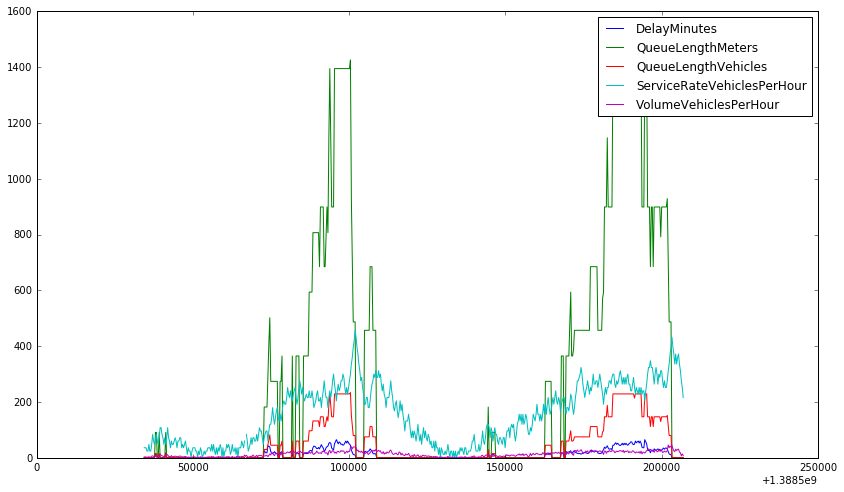

In [155]:
plt.figure(figsize=(14,8))

for metric in range(5):
    plt.plot(resp['GroupStarts'], resp['Values'][metric], label=resp['DataSources'][metric]['Metric'])
    
plt.legend()
plt.show()

## Add crossing data to mongo

In [7]:
metadata = json.loads('{"Crossings":[{"ID":134,"Name":"Peace Arch","DirectionsOfTravel":["Southbound","Northbound"],"LaneTypes":["Car","Nexus"]},{"ID":135,"Name":"Pacific Highway","DirectionsOfTravel":["Southbound","Northbound"],"LaneTypes":["Car","Bus","Fast","Nexus","Truck"]},{"ID":136,"Name":"Lynden/Aldergrove","DirectionsOfTravel":["Northbound","Southbound"],"LaneTypes":["Car","Truck"]},{"ID":137,"Name":"Sumas/Huntingdon","DirectionsOfTravel":["Northbound","Southbound"],"LaneTypes":["Car","Truck"]}]}')

In [8]:
metadata['Crossings']

[{u'DirectionsOfTravel': [u'Southbound', u'Northbound'],
  u'ID': 134,
  u'LaneTypes': [u'Car', u'Nexus'],
  u'Name': u'Peace Arch'},
 {u'DirectionsOfTravel': [u'Southbound', u'Northbound'],
  u'ID': 135,
  u'LaneTypes': [u'Car', u'Bus', u'Fast', u'Nexus', u'Truck'],
  u'Name': u'Pacific Highway'},
 {u'DirectionsOfTravel': [u'Northbound', u'Southbound'],
  u'ID': 136,
  u'LaneTypes': [u'Car', u'Truck'],
  u'Name': u'Lynden/Aldergrove'},
 {u'DirectionsOfTravel': [u'Northbound', u'Southbound'],
  u'ID': 137,
  u'LaneTypes': [u'Car', u'Truck'],
  u'Name': u'Sumas/Huntingdon'}]

In [13]:
client = pymongo.MongoClient()
db = client.border

In [61]:
db.crossing.insert_many(metadata['Crossings'])

In [9]:
crossings = metadata['Crossings']

## Request data

In [4]:
def get_crossing_data(xing_id, direction, lane, start, end):
    baseurl = 'http://www.cascadegatewaydata.com/Crossing/'
    basequery = 'data=sum-delay,sum-qmtr,sum-qveh,sum-rate,sum-vol,sum-avail&format=JSON'
    customquery = 'id={0}&start={1}&end={2}&dir={3}&lane={4}'.format(xing_id, start, end, direction, lane)

    url = "{0}?{1}&{2}".format(baseurl, basequery, customquery)
  
#     print url
    return get_json(url)

resp = get_crossing_data(134, 'Northbound', 'Car', '10/1/2015', '10/3/2015')

In [11]:
import datetime
import dateutil

from dateutil.relativedelta import relativedelta

def get_month_day_range(date):
    """
    For a date 'date' returns the start and end date for the month of 'date'.
    Month with 31 days:
    >>> date = datetime.date(2011, 7, 27)
    >>> get_month_day_range(date)
    (datetime.date(2011, 7, 1), datetime.date(2011, 7, 31))
    Month with 28 days:
    >>> date = datetime.date(2011, 2, 15)
    >>> get_month_day_range(date)
    (datetime.date(2011, 2, 1), datetime.date(2011, 2, 28))
    """
    last_day = date + relativedelta(day=1, months=+1, days=-1)
    first_day = date + relativedelta(day=1)
    return first_day, last_day

In [15]:
import time

for xing in crossings:
    for direction in xing['DirectionsOfTravel']:
        for lane in xing['LaneTypes']:
            for year in [2015]:
                for month in [12]:
                    if year == 2015 and month > 12:
                        break
                    data = {}    
                    
                    startstr, endstr = [dt.strftime('%m/%d/%Y') for dt in get_month_day_range(datetime.date(year, month, 1))]
                    start, end = get_month_day_range(datetime.datetime(year, month, 1))
                    data = get_crossing_data(xing['ID'], direction, lane, startstr, endstr)
                    
                    if 'ErrorMessages' in data:
                        print data
                        break
        
                    data['crossing_id'] = xing['ID']
                    data['dir'] = direction
                    data['lane'] = lane
                    data['start'] = start
                    data['end'] = end
#                     print data
                    db.data.insert_one(data)
                    
                    time.sleep(10)

In [34]:
start,end = get_month_day_range(datetime.datetime(2015, 11, 1))

# print start

# starttime = time.strptime(startstr, "%m/%d/%Y")
# startdate = datetime.datetime(*starttime[:6])
# print startdate
print type(datetime.datetime.strptime(startstr, "%m/%d/%Y"))
print type(start)

<type 'datetime.datetime'>
<type 'datetime.datetime'>


In [198]:
start, end = get_month_day_range(datetime.date(2015, 10, 1))
print start.strftime('%m/%d/%Y')

10/01/2015


## Fix dates

In [37]:
# Get all documents type 2 = string; type 9 = date
print db.data.find({ 'start': { '$type': 2 }}).count()

while True:
    doc = db.data.find_one({ 'start': { '$type': 2 } }, {'start': 1, 'end': 1})
    
    if doc is None or len(doc) == 0:
        break

    # Format dates
    starttime = time.strptime(doc['start'], "%m/%d/%Y")
    endtime = time.strptime(doc['end'], "%m/%d/%Y")

    startdate = datetime.datetime(*starttime[:6])
    enddate = datetime.datetime(*endtime[:6])

    # Update document with date
    db.data.update_one({'_id': doc['_id']}, {'$set': {'start': startdate, 'end': enddate}})

# print doc['_id']
# print doc['start'], doc['end']
# print startdate, enddate

print db.data.find({ 'start': { '$type': 2 }}).count()
print db.data.find({ 'start': { '$type': 9 }}).count()


0
0
2343


In [251]:
print db.data.find({ 'start': { '$type': 2 }}).count()
print db.data.find({ 'start': { '$type': 9 }}).count()

0
2332


## Now that we have all data, we can put it into Postgres in a better data model

### How much do we normalize?

#### For analysis, denormalized is better
* each crossing/direction/lane can be considered a single slice of data
* usability suffers from normalizing 
* not enough data to worry too much about duplication or performance
* simple data compression: N/S for direction, Peace/Pacific/Lynden/Sumas for crossing names

#### For a web app, more normalization will help
* selections for crossing, direction, lane

#### Best balance is a normalized data structure with view for analysis

Route
* routeId
* crossingId
* laneId
* dirId

Crossing
* crossingId
* crossingName (full name from API)
* crossingLabel (Peace/Sumas)
* latitude
* longitude

Direction
* dirId (N/S)
* dirName (Northbound/Southbound)

DirOptions   (not entirely necessary since each crossing has a N/S direction)
* crossingId
* dirId

Lane
* laneId
* laneName

LaneOptions
* crossingId
* laneId

Activity (5 minute grain)
* routeId
* timestamp
* delayMin
* queueMeters
* queueVehicles
* serviceRatePerHour
* volumePerHour
* data_avail

In [2]:
import psycopg2

In [10]:
conn = psycopg2.connect("dbname=border user=jng")
cur = conn.cursor()

In [22]:
print cur.fetchall();

[(2, 'Nexus'), (3, 'Bus'), (4, 'Fast'), (5, 'Truck')]


In [23]:
cur.close()
conn.close()